In [1]:
from mlflow.tracking.client import MlflowClient
from mlflow.entities import ViewType
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
import os
from scipy.special import softmax
from sklearn.metrics import confusion_matrix, classification_report
sns.set(color_codes=True)
%matplotlib inline
mlflow.set_tracking_uri("file:/data/logs/kristian/mlruns")

labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
WP = "params.quantization/weight_precision"
AP = "params.quantization/activation_precision"


In [11]:
model = "resnetensemble"

eval = mlflow.search_runs(
  experiment_ids="19",
  filter_string="tags.type = 'ensemble' and tags.ensamble_method = 'bagging'",
  output_format="pandas",
).iloc[0]

quant = mlflow.search_runs(
  experiment_ids="19",
  filter_string="tags.type = 'ensemble + quantization'",
  output_format="pandas",
).iloc[6]

prun = mlflow.search_runs(
    experiment_ids="19",
  filter_string="tags.type = 'ensemble + pruning' and tags.pruning_method = 'unstructured_l1'",
  output_format="pandas",
) #.iloc[0]

qp = mlflow.search_runs(
    experiment_ids="19",
  filter_string="tags.type = 'ensemble + quantization + pruning' and tags.pruning_method = 'unstructured_l1'",
  output_format="pandas",
).iloc[2]

print(quant[AP], quant[WP])
print(qp[AP], qp[WP])
#prun["params.model_0.25"]

7 8
7 8


In [12]:
def plot_cm(exp, file = "preds"):
    df = pd.read_csv(f"{exp['params.csv_path']}/{file}.csv")

    raw_preds = df.iloc[:,0:10].to_numpy()
    soft_preds = softmax(raw_preds, axis=1)
    preds = soft_preds.argmax(1)
    targs = df['targets'].to_numpy()

    cm = confusion_matrix(targs, preds)

    print(classification_report(targs, preds))
    sns.heatmap(cm)
    quantization = True if "params.quantization/weight_precision" in exp.keys() else False
    if quantization:
        plt.title(f'Quantization: WP: {exp["params.quantization/weight_precision"]} AP: {exp["params.quantization/activation_precision"]}')
    else:
        plt.title("Evaluation Test Set")

In [13]:
def get_preds(exp, file = "preds"):
    df = pd.read_csv(f"{exp['params.csv_path']}/{file}.csv")
    raw_preds = df.iloc[:,0:10].to_numpy()
    soft_preds = softmax(raw_preds, axis=1)
    preds = soft_preds.argmax(1)
    targs = df['targets'].to_numpy()

    return targs, preds

In [14]:
q_targs, q_preds = get_preds(quant, "q_preds")
targs, preds = get_preds(eval)
# p_targs, p_preds = get_preds(prun, 'p_preds')
qp_targs, qp_preds = get_preds(qp, 'q_preds')


In [15]:
cm = confusion_matrix(targs, preds)
q_cm = confusion_matrix(q_targs, q_preds)
#p_cm = confusion_matrix(p_targs, p_preds)
qp_cm = confusion_matrix(qp_targs, qp_preds)



cm_acc = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
q_cm_acc = q_cm.astype('float') / q_cm.sum(axis=1)[:, np.newaxis]
#p_cm_acc = p_cm.astype('float') / p_cm.sum(axis=1)[:, np.newaxis]
qp_cm_acc = qp_cm.astype('float') / qp_cm.sum(axis=1)[:, np.newaxis]



array([ 0.   ,  0.001,  0.004,  0.002,  0.002,  0.002, -0.002,  0.   ,
       -0.002,  0.002])

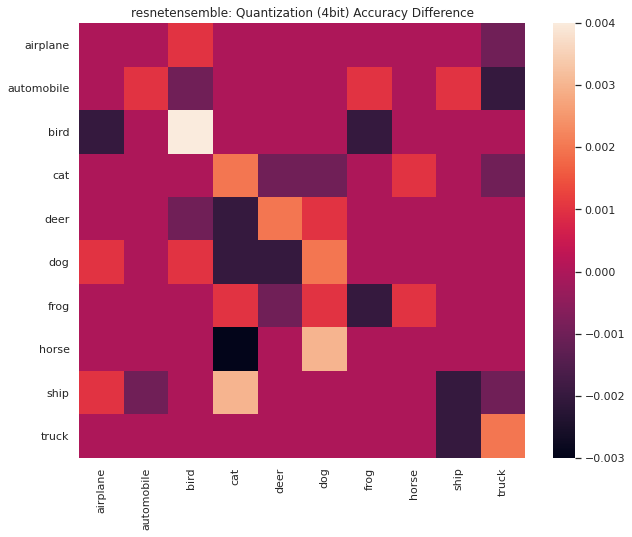

In [16]:
fig, ax = plt.subplots(figsize=(10,8))
plt.title(f"{model}: Quantization (4bit) Accuracy Difference")

sns.heatmap(q_cm_acc - cm_acc, xticklabels=labels, yticklabels=labels)

plt.savefig(f"/home/k.schwienbacher/quantization-robustness/data/class/{model}-quant-4.jpg")

np.diag(q_cm_acc - cm_acc)

array([ 0.012, -0.03 , -0.096, -0.099, -0.112, -0.024, -0.093, -0.035,
       -0.177, -0.04 ])

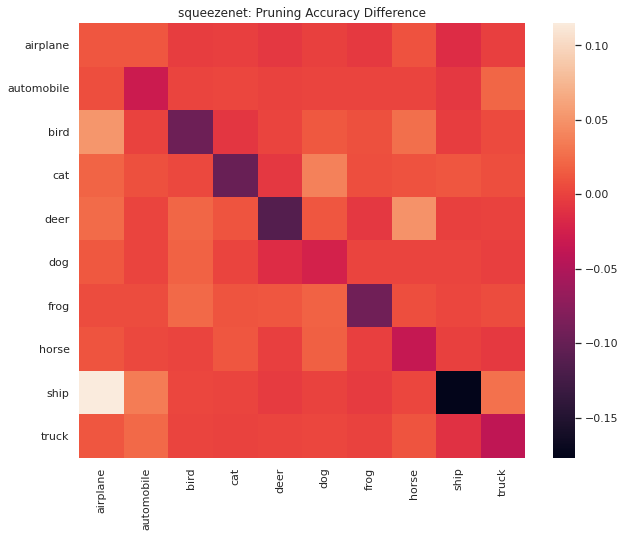

In [12]:
fig, ax = plt.subplots(figsize=(10,8))
plt.title(f"{model}: Pruning Accuracy Difference")
sns.heatmap(p_cm_acc - cm_acc, xticklabels=labels, yticklabels=labels)

plt.savefig(f"/home/k.schwienbacher/quantization-robustness/data/class/{model}-prun.jpg")
np.diag(p_cm_acc - cm_acc)



array([ 0.002, -0.03 , -0.038, -0.075, -0.052,  0.005, -0.01 , -0.048,
       -0.041, -0.031])

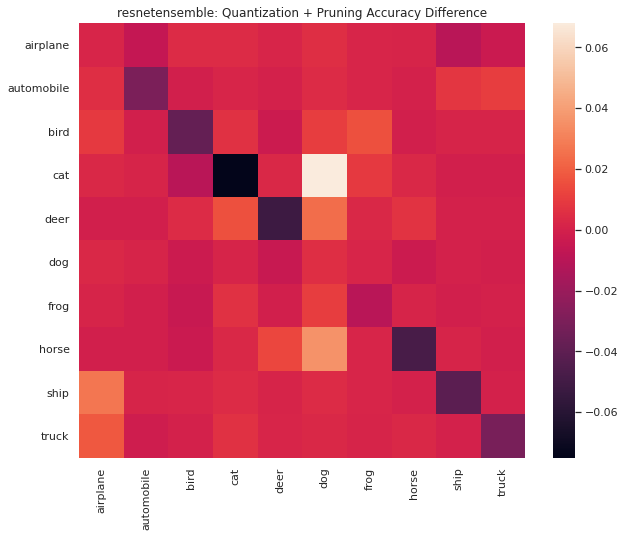

In [17]:
fig, ax = plt.subplots(figsize=(10,8))
plt.title(f"{model}: Quantization + Pruning Accuracy Difference")
sns.heatmap(qp_cm_acc - cm_acc, xticklabels=labels, yticklabels=labels)

plt.savefig(f"/home/k.schwienbacher/quantization-robustness/data/class/{model}-prun-quant-.jpg")

np.diag(qp_cm_acc - cm_acc)